# **Comprehensive Analysis Notebook**
This notebook Compares between Binary Classification, Multiclass Softmax Regression (Manual/PyTorch), and Multilayer Neural Network performances on the MNIST dataset.

## 1. Setup and Configuration

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch.nn as nn
import torch.optim as optim
import struct
from array import array
from os.path import join
import random
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

input_path = 'MNIST_Dataset'

## 2. Data Preparation Utilities (Multiclass and Binary)

In [4]:
def load_and_prepare_multiclass_data(random_state=SEED):
    # 1. Load data from torchvision
    train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True)

    # 2. Combine train and test sets to get all 70,000 samples
    X = torch.cat([train_dataset.data, test_dataset.data], dim=0)
    y = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

    # Convert to NumPy for sklearn splitting
    X_np = X.numpy()
    y_np = y.numpy()

    # 3. Perform 60/20/20 stratified split
    # (60% train, 40% temp)
    X_train_full, X_temp, y_train_full, y_temp = train_test_split(
        X_np, y_np, test_size=0.4, stratify=y_np, random_state=random_state
    )
    # (20% val, 20% test from 40% temp)
    X_val, X_test_final, y_val, y_test_final = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
    )

    # 4. Preprocess: Flatten and Normalize [0, 1]
    # Create NumPy versions (for manual softmax model)
    X_train_flat = X_train_full.reshape(-1, INPUT_SIZE).astype(np.float32) / 255.0
    X_val_flat = X_val.reshape(-1, INPUT_SIZE).astype(np.float32) / 255.0
    X_test_flat = X_test_final.reshape(-1, INPUT_SIZE).astype(np.float32) / 255.0
    y_test_raw_np = y_test_final # For final analysis

    # 5. Create Tensor versions (for PyTorch models)
    X_train_t = torch.tensor(X_train_flat, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_flat, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_flat, dtype=torch.float32)

    y_train_t = torch.tensor(y_train_full, dtype=torch.long)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    y_test_t = torch.tensor(y_test_final, dtype=torch.long)

    # Return all the variables the rest of the notebook expects
    return X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t, \
           X_train_flat, X_val_flat, X_test_flat, y_test_raw_np

In [5]:
class BinaryMNISTDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data.float().reshape(-1, INPUT_SIZE)
        self.targets = targets.float().unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def get_binary_dataloaders(batch_size=BATCH_SIZE, random_state=SEED):
    train_data = datasets.MNIST(
        root='./data', train=True, download=True
    )

    is_binary_mask = (train_data.targets == 0) | (train_data.targets == 1)
    X_full = train_data.data[is_binary_mask]
    Y_full = train_data.targets[is_binary_mask]

    X_full = X_full.float() / 255.0

    mean = 0.1307
    std = 0.3081
    X_full = (X_full - mean) / std


    X_train_val, X_test, Y_train_val, Y_test = train_test_split(
        X_full, Y_full, test_size=0.2, random_state=random_state, stratify=Y_full
    )

    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_val, Y_train_val, test_size=(0.2/0.8), random_state=random_state, stratify=Y_train_val
    )

    train_dataset = BinaryMNISTDataset(X_train, Y_train)
    val_dataset = BinaryMNISTDataset(X_val, Y_val)
    test_dataset = BinaryMNISTDataset(X_test, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
def create_multiclass_dataloaders(batch_size=BATCH_SIZE):
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## 3. Binary Classification (Scratch Implementation)

In [7]:
class BinaryLogisticRegression:
    def __init__(self, input_size):
        self.W = torch.randn(input_size, 1, device=DEVICE) * 0.01
        self.b = torch.zeros(1, device=DEVICE)
        self.W.requires_grad_(True)
        self.b.requires_grad_(True)

    def forward(self, x):
        linear = torch.matmul(x, self.W) + self.b
        y_pred = torch.sigmoid(linear)
        return y_pred

    def parameters(self):
        return [self.W, self.b]

def custom_binary_cross_entropy(y_pred, y_true):
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss.mean()

def calculate_binary_accuracy(y_pred, y_true):
    y_pred_class = (y_pred >= 0.5).float()
    correct = (y_pred_class == y_true).float().sum()
    return (correct / len(y_true)).item()

def train_model_binary(model, optimizer, train_loader, val_loader, loss_fn, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"Starting binary training on {DEVICE}...")

    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            epoch_train_loss += loss.item() * len(X_batch)
            epoch_train_acc += calculate_binary_accuracy(y_pred, y_batch) * len(X_batch)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_acc = epoch_train_acc / len(train_loader.dataset)

        epoch_val_loss, epoch_val_acc = 0.0, 0.0
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader:
                X_batch_val, y_batch_val = X_batch_val.to(DEVICE), y_batch_val.to(DEVICE)

                y_pred_val = model.forward(X_batch_val)
                loss_val = loss_fn(y_pred_val, y_batch_val)

                epoch_val_loss += loss_val.item() * len(X_batch_val)
                epoch_val_acc += calculate_binary_accuracy(y_pred_val, y_batch_val) * len(X_batch_val)

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        avg_val_acc = epoch_val_acc / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)

        print(f'Epoch {epoch+1:2d}/{epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_binary_model(model, test_loader, loss_fn):
    all_preds, all_targets = [], []
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch)

            total_loss += loss.item() * len(X_batch)
            y_pred_class = (y_pred >= 0.5).float()

            all_preds.extend(y_pred_class.cpu().numpy().flatten())
            all_targets.extend(y_batch.cpu().numpy().flatten())

    avg_loss = total_loss / len(test_loader.dataset)
    conf_matrix = confusion_matrix(all_targets, all_preds)
    final_acc = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(all_targets)

    return final_acc, conf_matrix, avg_loss, np.array(all_preds)


## 4. Multiclass Softmax Regression (Scratch/NumPy Implementation)

In [8]:
def initialize_weights(input_dim=INPUT_SIZE, num_classes=10):
    W = np.random.randn(input_dim, num_classes) * 0.01
    b = np.zeros((1, num_classes))
    return W, b

def softmax_forward(X, W, b):
    logits = X @ W + b
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return logits, probs

def calc_loss_and_accuracy(X, y, W, b):
    _, probs = softmax_forward(X, W, b)
    predicted_classes = np.argmax(probs, axis=1)
    accuracy = np.mean(predicted_classes == y) * 100

    n_samples = len(y)
    correct_class_probs = probs[np.arange(n_samples), y]
    loss = -np.mean(np.log(correct_class_probs + 1e-8))

    return loss, accuracy, predicted_classes

def train_epoch_sgd(X, y, W, b, learning_rate, batch_size):
    n_train = len(X)
    n_batches = n_train // batch_size

    indices = np.random.permutation(n_train)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    epoch_loss = 0

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        logits, probs = softmax_forward(X_batch, W, b)

        batch_size_actual = len(y_batch)
        correct_probs = probs[np.arange(batch_size_actual), y_batch]
        batch_loss = -np.mean(np.log(correct_probs + 1e-8))
        epoch_loss += batch_loss

        y_one_hot = np.zeros_like(probs)
        y_one_hot[np.arange(batch_size_actual), y_batch] = 1
        dlogits = (probs - y_one_hot) / batch_size_actual
        dW = X_batch.T @ dlogits
        db = np.sum(dlogits, axis=0, keepdims=True)

        W -= learning_rate * dW
        b -= learning_rate * db

    return W, b, epoch_loss

def train_manual_softmax(X_train, y_train, X_val, y_val, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):
    W, b = initialize_weights()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    n_train = len(X_train)
    n_batches = n_train // batch_size

    for i in range(num_epochs):
        W, b, l = train_epoch_sgd(X_train, y_train, W, b, learning_rate, batch_size)

        train_loss, train_acc, _ = calc_loss_and_accuracy(X_train, y_train, W, b)

        val_loss, val_acc, _ = calc_loss_and_accuracy(X_val, y_val, W, b)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return W, b, train_losses, train_accuracies, val_losses, val_accuracies

## 5. General PyTorch Utilities and Model Definitions

In [9]:
def train_pytorch_model_comp(model, train_loader, val_loader, criterion, optimizer, num_epochs, verbose=False):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc, _ = evaluate_pytorch_model_comp(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    training_time = time.time() - start_time
    return train_losses, train_accs, val_losses, val_accs, training_time

def evaluate_pytorch_model_comp(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy, np.array(predictions)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SoftmaxRegressionPyTorch(nn.Module):
    def __init__(self, input_dim=INPUT_SIZE, num_classes=10):
        super(SoftmaxRegressionPyTorch, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=INPUT_SIZE, hidden_layers=[256, 128], num_classes=10):
        super(NeuralNetwork, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## 6. Execution: Multiclass Data Loading and Preprocessing

In [10]:
X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t, X_train_flat, X_val_flat, X_test_flat, y_test_raw_np = load_and_prepare_multiclass_data()

print(f"Loaded Data Shapes:")
print(f"  Train (tensors): {X_train_t.shape}, {y_train_t.shape}")
print(f"  Validation (tensors): {X_val_t.shape}, {y_val_t.shape}")
print(f"  Test (tensors): {X_test_t.shape}, {y_test_t.shape}")

X_train_np = X_train_flat
X_val_np = X_val_flat
X_test_np = X_test_flat
y_train_np = y_train_t.numpy()
y_val_np = y_val_t.numpy()
y_test_np = y_test_raw_np

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.32MB/s]


Loaded Data Shapes:
  Train (tensors): torch.Size([42000, 784]), torch.Size([42000])
  Validation (tensors): torch.Size([14000, 784]), torch.Size([14000])
  Test (tensors): torch.Size([14000, 784]), torch.Size([14000])


## 7. Execution: Binary Classification (0s and 1s)

In [12]:
train_loader_binary, val_loader_binary, test_loader_binary = get_binary_dataloaders()

model_binary = BinaryLogisticRegression(INPUT_SIZE)
optimizer_binary = torch.optim.SGD(model_binary.parameters(), lr=0.01)

train_losses, val_losses, train_accuracies, val_accuracies = train_model_binary(
    model=model_binary,
    optimizer=optimizer_binary,
    train_loader=train_loader_binary,
    val_loader=val_loader_binary,
    loss_fn=custom_binary_cross_entropy,
    epochs=20
)

test_acc, conf_matrix, test_loss, test_preds = evaluate_binary_model(
    model=model_binary,
    test_loader=test_loader_binary,
    loss_fn=custom_binary_cross_entropy
)

print("\nFinal Test Set Results (Binary Classification)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Starting binary training on cpu...
Epoch  1/20 | Train Loss: 0.0506, Acc: 0.9916 | Val Loss: 0.0191, Acc: 0.9961
Epoch  2/20 | Train Loss: 0.0137, Acc: 0.9983 | Val Loss: 0.0137, Acc: 0.9968
Epoch  3/20 | Train Loss: 0.0100, Acc: 0.9983 | Val Loss: 0.0117, Acc: 0.9964
Epoch  4/20 | Train Loss: 0.0082, Acc: 0.9986 | Val Loss: 0.0106, Acc: 0.9964
Epoch  5/20 | Train Loss: 0.0070, Acc: 0.9987 | Val Loss: 0.0099, Acc: 0.9964
Epoch  6/20 | Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.0094, Acc: 0.9968
Epoch  7/20 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.0090, Acc: 0.9968
Epoch  8/20 | Train Loss: 0.0052, Acc: 0.9989 | Val Loss: 0.0087, Acc: 0.9968
Epoch  9/20 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.0085, Acc: 0.9972
Epoch 10/20 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0084, Acc: 0.9972
Epoch 11/20 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0082, Acc: 0.9972
Epoch 12/20 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.0081, Acc: 0.9972
Epoch 13/20 | Train Loss: 0.0

## 8. Execution: Multiclass Softmax Regression (Manual)

In [13]:
W, b = initialize_weights()
initial_loss, initial_accuracy,_= calc_loss_and_accuracy(X_train_np, y_train_np, W, b)

print(f"Initial accuracy with random weights: {initial_accuracy:.2f}%")
print(f"Initial loss: {initial_loss:.4f}")

W_manual, b_manual, train_losses_manual, train_accuracies_manual, val_losses_manual, val_accuracies_manual = train_manual_softmax(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.01, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

test_loss_manual, test_acc_manual, test_pred_manual = calc_loss_and_accuracy(X_test_np, y_test_np, W_manual, b_manual)

print("\nFinal Manual Softmax Test Results:")
print(f"Test Loss: {test_loss_manual:.4f}")
print(f"Test Accuracy: {test_acc_manual:.2f}%")

Initial accuracy with random weights: 8.03%
Initial loss: 2.3271

Final Manual Softmax Test Results:
Test Loss: 0.3046
Test Accuracy: 91.33%


## 9. Hyperparameter Analysis (Using Neural Network Model)

In [14]:
def plot_results(results_dict, title_prefix=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['blue', 'green', 'orange', 'red', 'purple']

    for i, (name, data) in enumerate(results_dict.items()):
        color = colors[i % len(colors)]

        ax1.plot(data['train_losses'], label=name, color=color, linewidth=2)

        ax2.plot(data['val_accs'], label=name, color=color, linewidth=2)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title(f'{title_prefix} Training Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax2.set_title(f'{title_prefix} Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### 9.1: Learning Rate Analysis

LEARNING RATE ANALYSIS

Training with learning rate = 0.001
  Final Val Acc: 90.13%, Test Acc: 89.93%, Time: 145.3s

Training with learning rate = 0.01
  Final Val Acc: 96.69%, Test Acc: 96.82%, Time: 151.7s

Training with learning rate = 0.1
  Final Val Acc: 97.77%, Test Acc: 97.90%, Time: 142.5s

Training with learning rate = 1.0
  Final Val Acc: 97.56%, Test Acc: 97.46%, Time: 149.8s


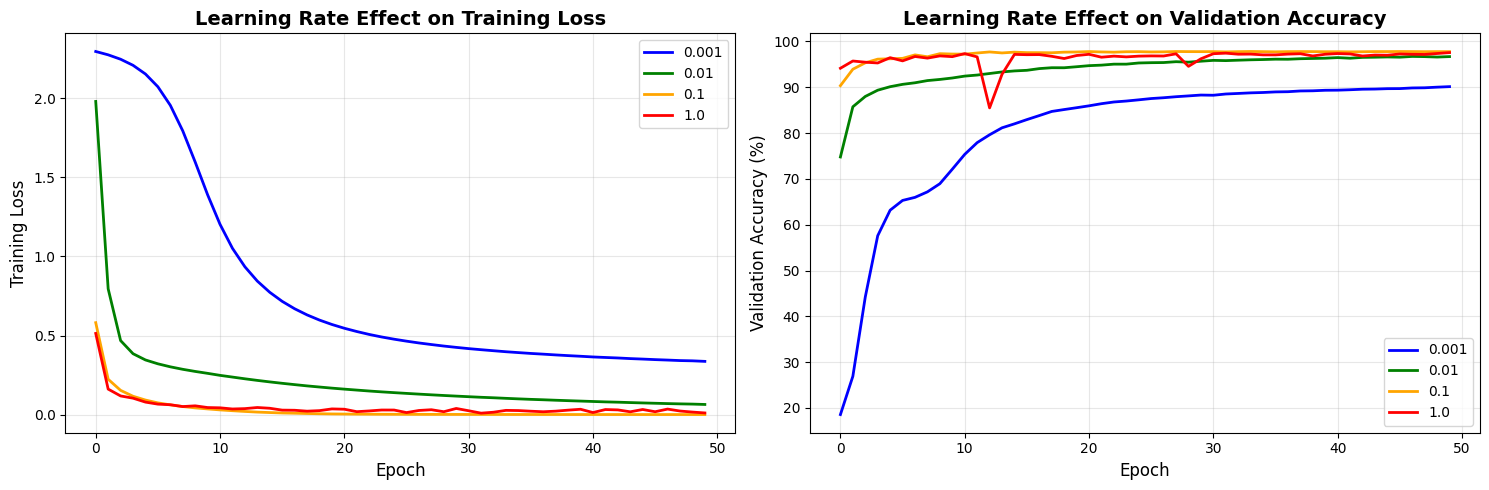


Learning Rate Summary:
LR         Final Val Acc   Test Acc     Time (s)  
Best Learning Rate: 0.1
--------------------------------------------------
0.001      90.13          % 89.93       % 145.3     
0.01       96.69          % 96.82       % 151.7     
0.1        97.77          % 97.90       % 142.5     
1.0        97.56          % 97.46       % 149.8     


In [15]:
print("="*60)
print("LEARNING RATE ANALYSIS")
print("="*60)

learning_rates = [0.001, 0.01, 0.1, 1.0]
results_lr = {}
train_loader, val_loader, test_loader = create_multiclass_dataloaders(batch_size=64)

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model = NeuralNetwork(hidden_layers=[256, 128])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, train_accs, val_losses, val_accs, train_time = train_pytorch_model_comp(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, verbose=False
    )
    test_loss, test_acc, _ = evaluate_pytorch_model_comp(model, test_loader, criterion)

    results_lr[lr] = {
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs,
        'test_acc': test_acc, 'train_time': train_time
    }
    print(f"  Final Val Acc: {val_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%, Time: {train_time:.1f}s")
best_lr = max(results_lr, key=lambda lr: results_lr[lr]['val_accs'][-1])
plot_results(results_lr, title_prefix='Learning Rate Effect on')

print("\nLearning Rate Summary:")
print(f"{'LR':<10} {'Final Val Acc':<15} {'Test Acc':<12} {'Time (s)':<10}")
print(f"Best Learning Rate: {best_lr}")
print("-" * 50)
for lr, data in results_lr.items():
    print(f"{lr:<10} {data['val_accs'][-1]:<15.2f}% {data['test_acc']:<12.2f}% {data['train_time']:<10.1f}")

### 9.2: Batch Size Analysis

BATCH SIZE ANALYSIS

Training with batch size = 16
  Final Val Acc: 98.06%, Test Acc: 98.22%, Time: 310.7s

Training with batch size = 32
  Final Val Acc: 97.91%, Test Acc: 98.16%, Time: 195.8s

Training with batch size = 64
  Final Val Acc: 97.77%, Test Acc: 98.02%, Time: 141.9s

Training with batch size = 128
  Final Val Acc: 97.74%, Test Acc: 97.74%, Time: 116.8s


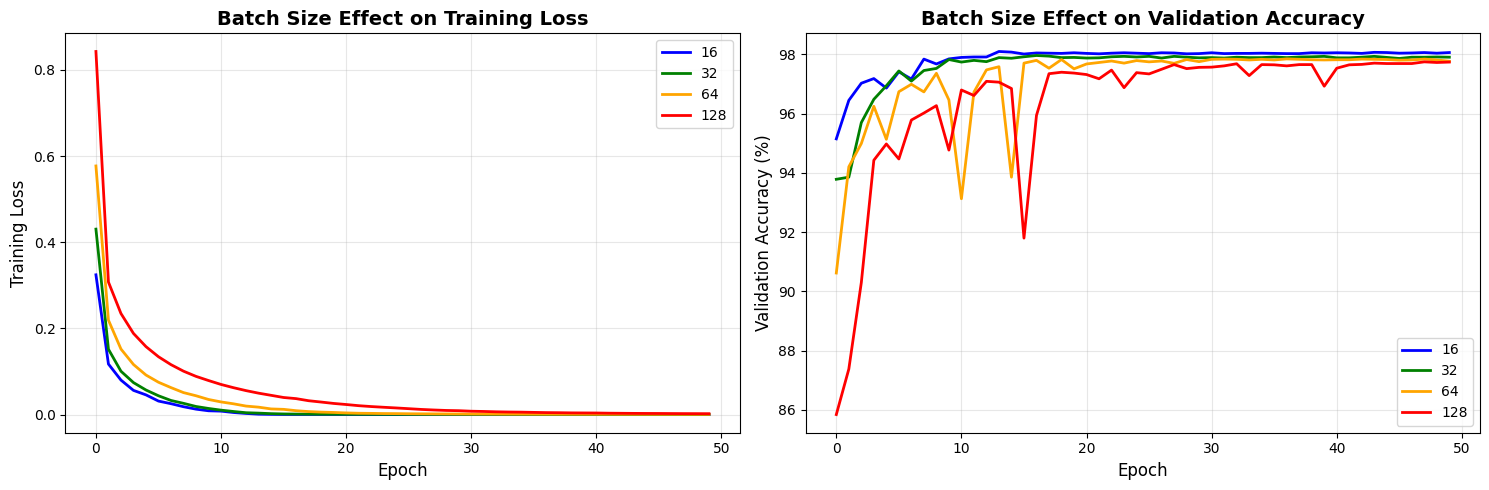


Batch Size Summary:
BS         Final Val Acc   Test Acc     Time (s)  
Best Batch Size: 16
--------------------------------------------------
16         98.06          % 98.22       % 310.7     
32         97.91          % 98.16       % 195.8     
64         97.77          % 98.02       % 141.9     
128        97.74          % 97.74       % 116.8     


In [16]:
print("="*60)
print("BATCH SIZE ANALYSIS")
print("="*60)

batch_sizes = [16, 32, 64, 128]
results_bs = {}

for bs in batch_sizes:
    print(f"\nTraining with batch size = {bs}")
    train_loader, val_loader, test_loader = create_multiclass_dataloaders(batch_size=bs)
    model = NeuralNetwork(hidden_layers=[256, 128])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=best_lr)

    train_losses, train_accs, val_losses, val_accs, train_time = train_pytorch_model_comp(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, verbose=False
    )
    test_loss, test_acc, _ = evaluate_pytorch_model_comp(model, test_loader, criterion)

    results_bs[bs] = {
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs,
        'test_acc': test_acc, 'train_time': train_time
    }
    print(f"  Final Val Acc: {val_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%, Time: {train_time:.1f}s")

plot_results(results_bs, title_prefix='Batch Size Effect on')
best_bs = max(results_bs, key=lambda bs: results_bs[bs]['val_accs'][-1])

print("\nBatch Size Summary:")
print(f"{'BS':<10} {'Final Val Acc':<15} {'Test Acc':<12} {'Time (s)':<10}")
print(f"Best Batch Size: {best_bs}")
print("-" * 50)
for bs, data in results_bs.items():
    print(f"{bs:<10} {data['val_accs'][-1]:<15.2f}% {data['test_acc']:<12.2f}% {data['train_time']:<10.1f}")

### 9.3: Network Depth Analysis

NETWORK DEPTH ANALYSIS

Training architecture: 2_layers - [256, 128]
  Parameters: 235,146, Final Val Acc: 96.60%, Test Acc: 96.86%

Training architecture: 3_layers - [256, 128, 64]
  Parameters: 242,762, Final Val Acc: 96.49%, Test Acc: 96.64%

Training architecture: 4_layers - [256, 128, 64, 32]
  Parameters: 244,522, Final Val Acc: 96.91%, Test Acc: 97.00%

Training architecture: 5_layers - [256, 128, 64, 32, 16]
  Parameters: 244,890, Final Val Acc: 96.19%, Test Acc: 96.38%


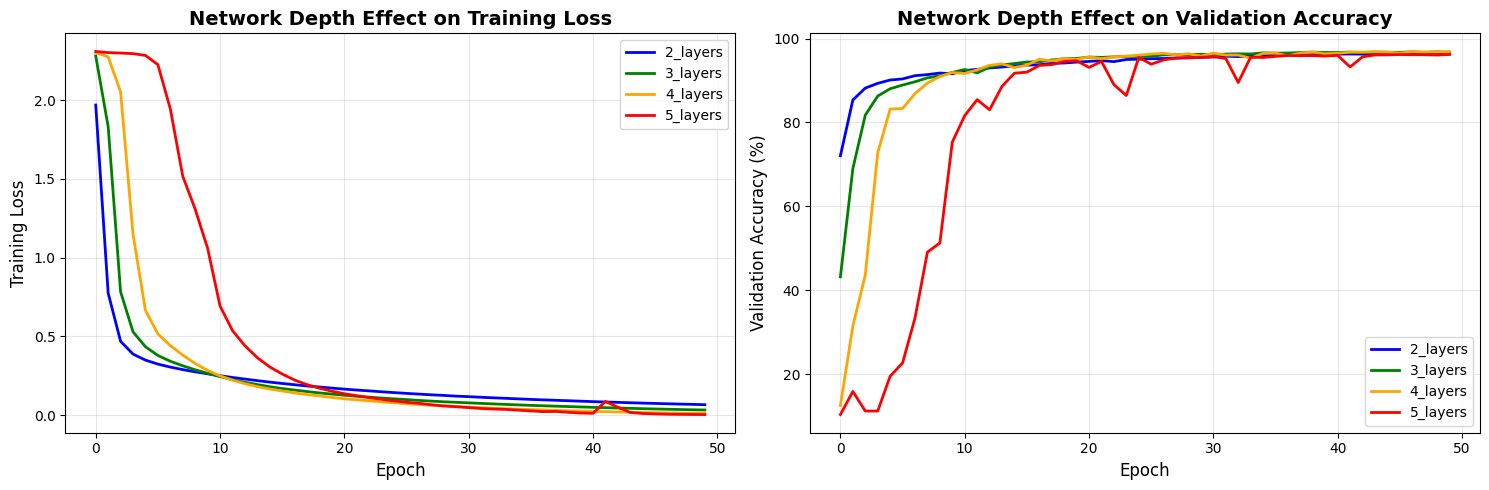


Network Depth Summary:
Depth      Parameters   Final Val Acc   Test Acc    
Best architecture: 4_layers
--------------------------------------------------
2_layers   235146,,,,,, 96.60          % 96.86%
3_layers   242762,,,,,, 96.49          % 96.64%
4_layers   244522,,,,,, 96.91          % 97.00%
5_layers   244890,,,,,, 96.19          % 96.38%


In [17]:
print("="*60)
print("NETWORK DEPTH ANALYSIS")
print("="*60)

architectures = {
    '2_layers': [256, 128],
    '3_layers': [256, 128, 64],
    '4_layers': [256, 128, 64, 32],
    '5_layers': [256, 128, 64, 32, 16]
}
results_arch = {}
train_loader, val_loader, test_loader = create_multiclass_dataloaders(batch_size=64)

for name, layers in architectures.items():
    print(f"\nTraining architecture: {name} - {layers}")
    model = NeuralNetwork(hidden_layers=layers).to(DEVICE) # Move model to device
    n_params = count_parameters(model)
    criterion = nn.CrossEntropyLoss().to(DEVICE) # Move criterion to device
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses, train_accs, val_losses, val_accs, train_time = train_pytorch_model_comp(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, verbose=False
    )
    test_loss, test_acc, _ = evaluate_pytorch_model_comp(model, test_loader, criterion)

    results_arch[name] = {
        'layers': layers, 'n_params': n_params,
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs,
        'test_acc': test_acc, 'train_time': train_time,
        'model': model # Store the trained model
    }
    print(f"  Parameters: {n_params:,}, Final Val Acc: {val_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%")

plot_results(results_arch, title_prefix='Network Depth Effect on')
best_arch_name = max(results_arch, key=lambda name: results_arch[name]['test_acc'])
best_arch_data = results_arch[best_arch_name]

print("\nNetwork Depth Summary:")
print(f"{'Depth':<10} {'Parameters':<12} {'Final Val Acc':<15} {'Test Acc':<12}")
print(f"Best architecture: {best_arch_name}")
print("-" * 50)
for name, data in results_arch.items():
    print(f"{name:<10} {data['n_params']:,<12} {data['val_accs'][-1]:<15.2f}% {data['test_acc']:.2f}%")

### 9.4: Network Width Analysis

NETWORK WIDTH ANALYSIS

Training architecture: small_4_layers - [64, 32, 16, 8]
  Parameters: 53,074, Final Val Acc: 93.73%, Test Acc: 93.95%

Training architecture: medium_4_layers - [128, 64, 32, 16]
  Parameters: 111,514, Final Val Acc: 96.01%, Test Acc: 96.07%

Training architecture: large_4_layers - [256, 128, 64, 32]
  Parameters: 244,522, Final Val Acc: 96.83%, Test Acc: 97.19%

Training architecture: xlarge_4_layers - [512, 256, 128, 64]
  Parameters: 575,050, Final Val Acc: 97.11%, Test Acc: 97.19%


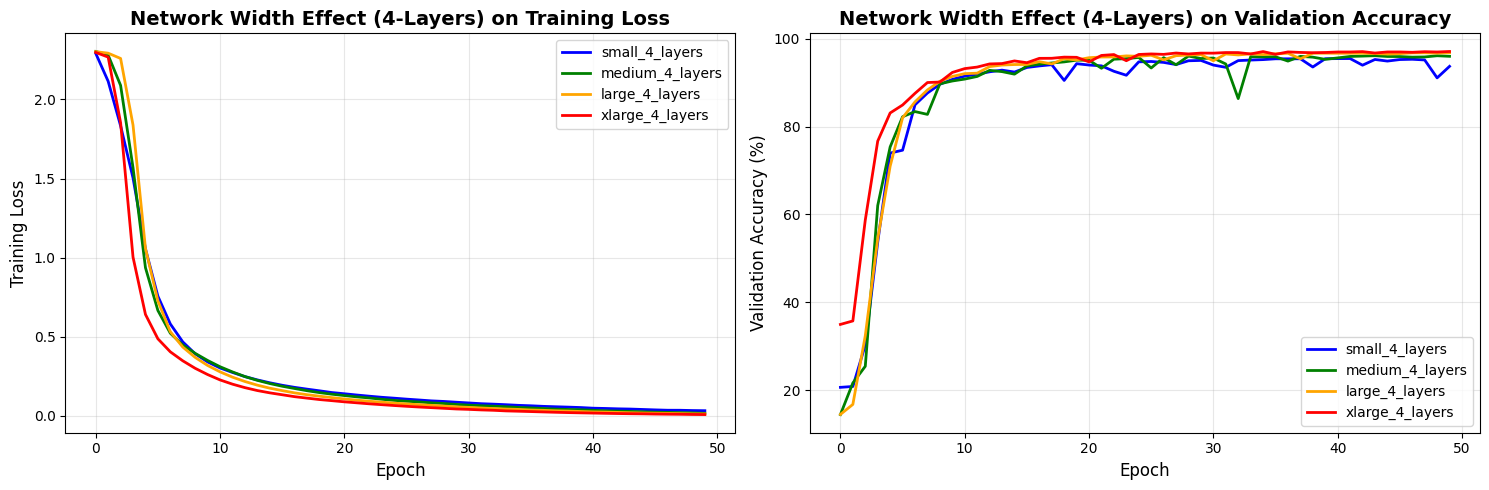


Network Width Summary (4-Layers):
Width                Parameters   Final Val Acc   Test Acc    
Best architecture: large_4_layers
------------------------------------------------------------
small_4_layers       53074,,,,,,, 93.73          % 93.95%
medium_4_layers      111514,,,,,, 96.01          % 96.07%
large_4_layers       244522,,,,,, 96.83          % 97.19%
xlarge_4_layers      575050,,,,,, 97.11          % 97.19%


In [18]:
print("="*60)
print("NETWORK WIDTH ANALYSIS")
print("="*60)

architectures_width_4_layers = {
    'small_4_layers':  [64, 32, 16, 8],
    'medium_4_layers': [128, 64, 32, 16],
    'large_4_layers':  [256, 128, 64, 32], # This was your winner from the depth test
    'xlarge_4_layers': [512, 256, 128, 64]
}

# --- Use a new dictionary to store these results ---
results_width_4L = {}

# 2. Get Dataloaders (same as before)
train_loader, val_loader, test_loader = create_multiclass_dataloaders(batch_size=64)

# 3. Loop through your new 4-layer architectures
for name, layers in architectures_width_4_layers.items():
    print(f"\nTraining architecture: {name} - {layers}")
    model = NeuralNetwork(hidden_layers=layers)
    n_params = count_parameters(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses, train_accs, val_losses, val_accs, train_time = train_pytorch_model_comp(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, verbose=False
    )
    test_loss, test_acc, _ = evaluate_pytorch_model_comp(model, test_loader, criterion)

    results_width_4L[name] = {
        'config': layers, 'n_params': n_params,
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs,
        'test_acc': test_acc, 'train_time': train_time
    }
    print(f"  Parameters: {n_params:,}, Final Val Acc: {val_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%")

# 4. Plot results (using the new dictionary)
plot_results(results_width_4L, title_prefix='Network Width Effect (4-Layers) on')
best_width_name_4L = max(results_width_4L, key=lambda name: results_width_4L[name]['test_acc'])
best_width_data_4L = results_width_4L[best_width_name_4L]

# 5. Print Summary (using the new dictionary)
print("\nNetwork Width Summary (4-Layers):")
print(f"{'Width':<20} {'Parameters':<12} {'Final Val Acc':<15} {'Test Acc':<12}")
print(f"Best architecture: {best_width_name_4L}")
print("-" * 60)
for name, data in results_width_4L.items():
    print(f"{name:<20} {data['n_params']:,<12} {data['val_accs'][-1]:<15.2f}% {data['test_acc']:.2f}%")

## 10. Final Model Comparison

In [19]:
def plot_confusion_matrices(y_true, y_pred_manual, y_pred_pytorch, y_pred_nn, y_true_binary=None, y_pred_binary=None):
    fig, axs = plt.subplots(1, 4, figsize=(32, 7)) # Increased figure size and added an extra subplot

    cm_manual = confusion_matrix(y_true, y_pred_manual)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=np.arange(10))
    disp1.plot(cmap='Blues', ax=axs[0], values_format='d')
    axs[0].set_title('Softmax Regression (Manual)')

    cm_pytorch = confusion_matrix(y_true, y_pred_pytorch)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=np.arange(10))
    disp2.plot(cmap='Greens', ax=axs[1], values_format='d')
    axs[1].set_title('Softmax Regression (PyTorch)')

    cm_nn = confusion_matrix(y_true, y_pred_nn)
    disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=np.arange(10))
    disp3.plot(cmap='Reds', ax=axs[2], values_format='d')
    axs[2].set_title('Neural Network')

    if y_true_binary is not None and y_pred_binary is not None:
        cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
        disp4 = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=[0, 1]) # Assuming binary is 0 and 1
        disp4.plot(cmap='Purples', ax=axs[3], values_format='d')
        axs[3].set_title('Binary Logistic Regression')


    plt.tight_layout()
    plt.show()

    return cm_manual, cm_pytorch, cm_nn, cm_binary # Return the binary confusion matrix as well

def calc_per_class_accuracy(y_true, y_pred, num_classes=10):
    per_class_acc = []

    for class_idx in range(num_classes):
        class_mask = (y_true == class_idx)
        class_correct = np.sum((y_pred == class_idx) & class_mask)
        class_total = np.sum(class_mask)
        acc = (class_correct / class_total) * 100 if class_total > 0 else 0
        per_class_acc.append(acc)

    return per_class_acc

def plot_per_class_accuracy_comp(acc_softmax, acc_nn, y_true, acc_binary=None, y_true_binary=None):
    print("PER-CLASS ACCURACY ANALYSIS\n")

    print("Class | Softmax Acc | NN Acc | Test Samples")
    print("-" * 55)
    for i in range(10):
        print(f"  {i}   |   {acc_softmax[i]:5.2f}%  |   {acc_nn[i]:5.2f}%   |     {np.sum(y_true == i):4d}")

    if acc_binary is not None and y_true_binary is not None:
        print("\nBinary Classification Accuracy (Classes 0 and 1):")
        print("Class | Binary Acc | Test Samples")
        print("-" * 35)
        for i in [0, 1]:
             print(f"  {i}   |   {acc_binary[i]:5.2f}%   |     {np.sum(y_true_binary == i):4d}")


    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(10)
    width = 0.35

    bars1 = ax.bar(x - width/2, acc_softmax, width, label='Softmax', color='steelblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, acc_nn, width, label='Neural Network', color='seagreen', edgecolor='black')

    ax.set_xlabel('Digit Class', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_ylim([0, 105])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return np.argmax(acc_softmax), np.argmin(acc_softmax), np.argmax(acc_nn), np.argmin(acc_nn)

FINAL MODEL COMPARISON

1. Evaluating Softmax Regression (Manual)...
 Test Accuracy: 91.33%

2. Evaluating Softmax Regression (PyTorch)...

2. Training and Evaluating Softmax Regression (PyTorch) for comparison...
 Test Accuracy: 89.60%

3. Evaluating Best Neural Network...
 Test Accuracy: 97.00%

4. Evaluating Binary Logistic Regression...
 Test Accuracy: 99.80%

Generating Comparison Plots...


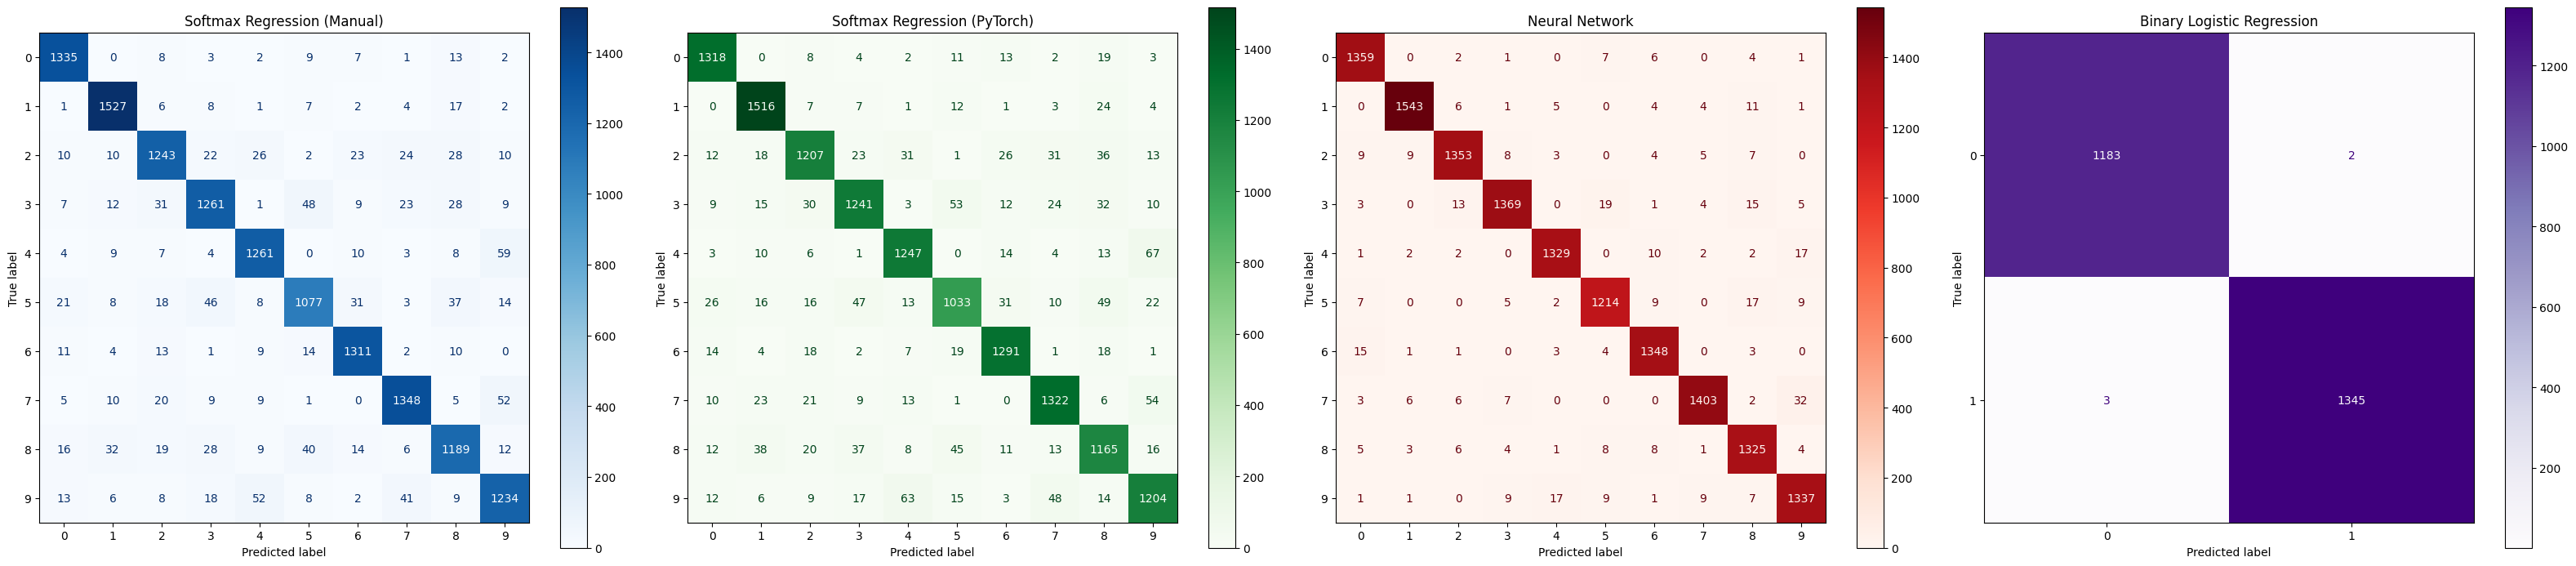

PER-CLASS ACCURACY ANALYSIS

Class | Softmax Acc | NN Acc | Test Samples
-------------------------------------------------------
  0   |   95.51%  |   98.48%   |     1380
  1   |   96.25%  |   97.97%   |     1575
  2   |   86.34%  |   96.78%   |     1398
  3   |   86.84%  |   95.80%   |     1429
  4   |   91.36%  |   97.36%   |     1365
  5   |   81.79%  |   96.12%   |     1263
  6   |   93.89%  |   98.04%   |     1375
  7   |   90.61%  |   96.16%   |     1459
  8   |   85.35%  |   97.07%   |     1365
  9   |   86.56%  |   96.12%   |     1391

Binary Classification Accuracy (Classes 0 and 1):
Class | Binary Acc | Test Samples
-----------------------------------
  0   |   99.83%   |     1185
  1   |   99.78%   |     1348


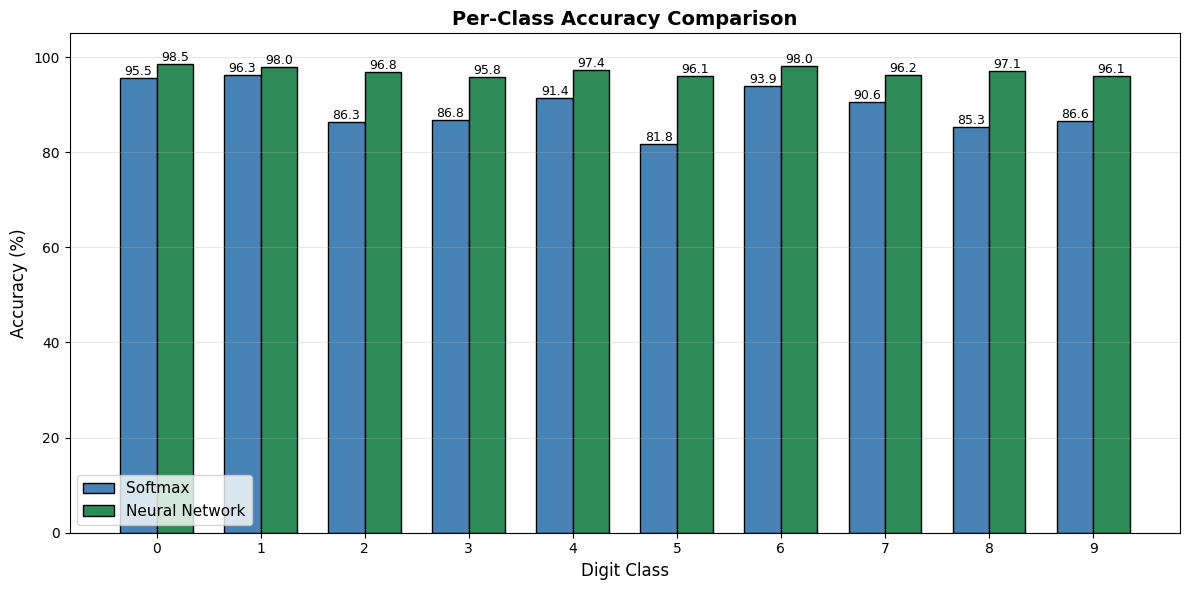


Summary of Test Accuracies:
Softmax Regression (Manual): 91.33%
Softmax Regression (PyTorch): 89.60%
Neural Network: 97.00%
Binary Logistic Regression: 99.80%


In [20]:
print("=" * 60)
print("FINAL MODEL COMPARISON")
print("=" * 60)

# Use already created dataloaders
train_loader, val_loader, test_loader = create_multiclass_dataloaders(batch_size=BATCH_SIZE)
_, _, test_loader_binary = get_binary_dataloaders(batch_size=BATCH_SIZE)

final_models = {}

# 1. Softmax Regression (Manual)
print("\n1. Evaluating Softmax Regression (Manual)...")
test_loss_manual, test_acc_manual, test_pred_manual = calc_loss_and_accuracy(X_test_np, y_test_np, W_manual, b_manual)
final_models['Softmax Regression (Manual)'] = {
    'test_acc': test_acc_manual,
    'predictions': test_pred_manual
}
print(f" Test Accuracy: {test_acc_manual:.2f}%")

# 2. Softmax Regression (PyTorch)
try:
    print("\n2. Evaluating Softmax Regression (PyTorch)...")
    test_loss1, test_acc1, preds1 = evaluate_pytorch_model_comp(model1, test_loader, nn.CrossEntropyLoss())
    final_models['Softmax Regression (PyTorch)'] = {
        'test_acc': test_acc1,
        'predictions': preds1
    }
    print(f" Test Accuracy: {test_acc1:.2f}%")
except NameError:
    print("\n2. Training and Evaluating Softmax Regression (PyTorch) for comparison...")
    model1 = SoftmaxRegressionPyTorch(input_dim=INPUT_SIZE, num_classes=10).to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.SGD(model1.parameters(), lr=0.01)
    train_pytorch_model_comp(model1, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    test_loss1, test_acc1, preds1 = evaluate_pytorch_model_comp(model1, test_loader, criterion)
    final_models['Softmax Regression (PyTorch)'] = {
        'test_acc': test_acc1,
        'predictions': preds1
    }
    print(f" Test Accuracy: {test_acc1:.2f}%")

# 3. Best Neural Network (using architecture from depth analysis)
try:
    print("\n3. Evaluating Best Neural Network...")
    best_arch_name = max(results_arch, key=lambda name: results_arch[name]['test_acc'])
    best_nn_model = results_arch[best_arch_name]['model'].to(DEVICE)
    test_loss_nn, test_acc_nn, preds_nn = evaluate_pytorch_model_comp(best_nn_model, test_loader, nn.CrossEntropyLoss())
    final_models['Neural Network'] = {
        'test_acc': test_acc_nn,
        'predictions': preds_nn
    }
    print(f" Test Accuracy: {test_acc_nn:.2f}%")
except NameError:
    print("\n3. Training and Evaluating Default Neural Network for comparison...")
    model3 = NeuralNetwork(input_dim=INPUT_SIZE, hidden_layers=[256, 128, 64], num_classes=10).to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.SGD(model3.parameters(), lr=0.01)
    train_pytorch_model_comp(model3, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    test_loss_nn, test_acc_nn, preds_nn = evaluate_pytorch_model_comp(model3, test_loader, criterion)
    final_models['Neural Network'] = {
        'test_acc': test_acc_nn,
        'predictions': preds_nn
    }
    print(f" Test Accuracy: {test_acc_nn:.2f}%")

# 4. Binary Logistic Regression
print("\n4. Evaluating Binary Logistic Regression...")

test_acc_binary, conf_matrix_binary, test_loss_binary, preds_binary = evaluate_binary_model(
    model=model_binary,
    test_loader=test_loader_binary,
    loss_fn=custom_binary_cross_entropy
)

final_models['Binary Logistic Regression'] = {
    'test_acc': test_acc_binary * 100,
    'predictions': preds_binary
}
print(f" Test Accuracy: {test_acc_binary * 100:.2f}%")

# Plotting and Analysis
print("\nGenerating Comparison Plots...")

cm_manual, cm_pytorch, cm_nn, cm_binary = plot_confusion_matrices(
    y_test_np,
    final_models['Softmax Regression (Manual)']['predictions'],
    final_models['Softmax Regression (PyTorch)']['predictions'],
    final_models['Neural Network']['predictions'],
    y_true_binary=np.array(test_loader_binary.dataset.targets.flatten()),
    y_pred_binary=np.array(final_models['Binary Logistic Regression']['predictions']).flatten()
)

# Recalculate per-class accuracy using stored predictions
acc_softmax_manual = calc_per_class_accuracy(y_test_np, final_models['Softmax Regression (Manual)']['predictions'])
acc_softmax_pytorch = calc_per_class_accuracy(y_test_np, final_models['Softmax Regression (PyTorch)']['predictions'])
acc_nn = calc_per_class_accuracy(y_test_np, final_models['Neural Network']['predictions'])
acc_binary = calc_per_class_accuracy(
    np.array(test_loader_binary.dataset.targets.flatten()),
    np.array(final_models['Binary Logistic Regression']['predictions']).flatten(),
    num_classes=2
)

# Plot per-class comparison
plot_per_class_accuracy_comp(
    acc_softmax_pytorch,
    acc_nn,
    y_test_np,
    acc_binary=acc_binary,
    y_true_binary=np.array(test_loader_binary.dataset.targets.flatten())
)

print("\nSummary of Test Accuracies:")
print(f"Softmax Regression (Manual): {final_models['Softmax Regression (Manual)']['test_acc']:.2f}%")
print(f"Softmax Regression (PyTorch): {final_models['Softmax Regression (PyTorch)']['test_acc']:.2f}%")
print(f"Neural Network: {final_models['Neural Network']['test_acc']:.2f}%")
print(f"Binary Logistic Regression: {final_models['Binary Logistic Regression']['test_acc']:.2f}%")


Number of misclassified examples by Neural Network: 420
Number of misclassified examples by PyTorch Softmax: 1456

Examples of misclassifications by Neural Network:


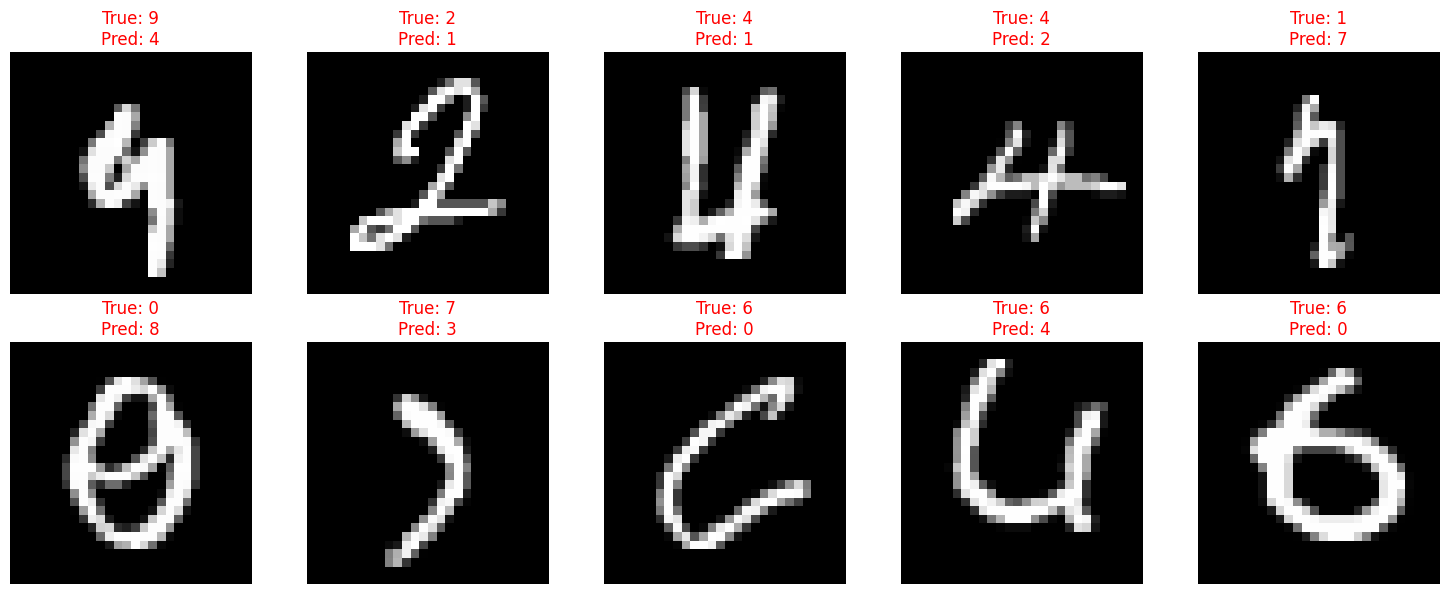


Examples of misclassifications by PyTorch Softmax Regression:


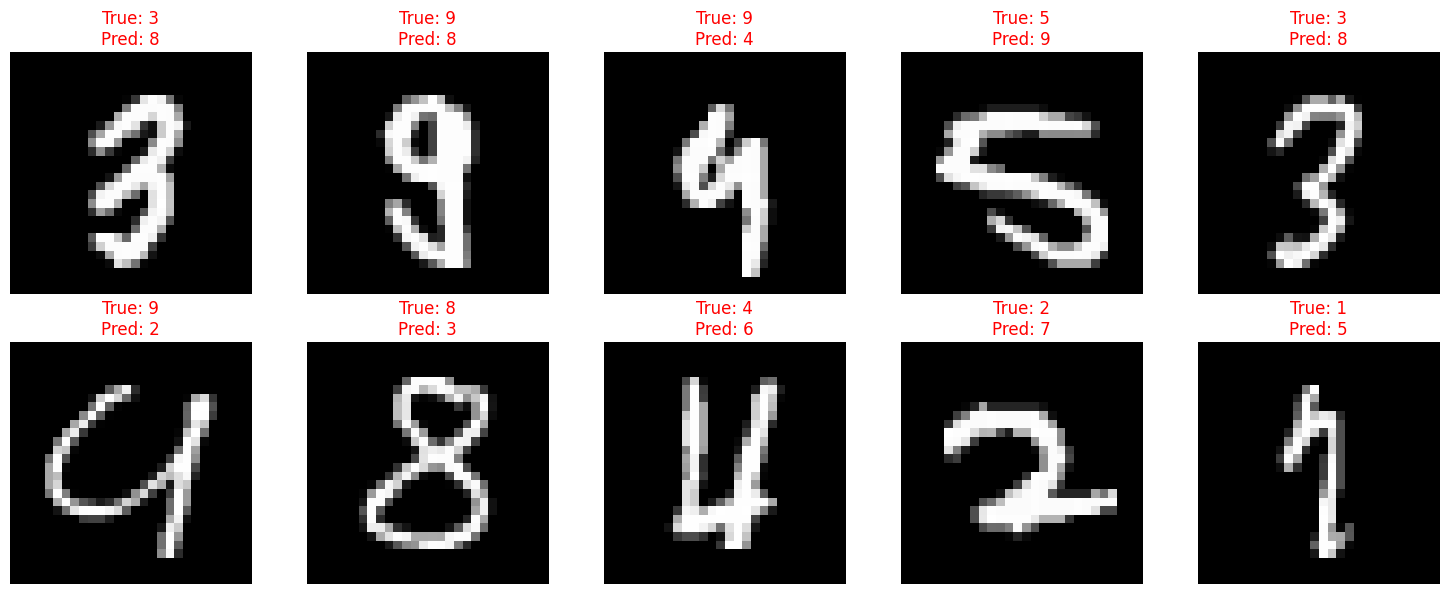

In [22]:
# Get predictions and true labels for the Neural Network and Softmax models
nn_predictions = final_models['Neural Network']['predictions']
softmax_predictions_pytorch = final_models['Softmax Regression (PyTorch)']['predictions']
y_true = y_test_np # True labels from the multiclass test set

# Find indices where the Neural Network misclassified
nn_misclassified_indices = np.where(nn_predictions != y_true)[0]

# Find indices where the PyTorch Softmax model misclassified
softmax_misclassified_indices = np.where(softmax_predictions_pytorch != y_true)[0]

print(f"Number of misclassified examples by Neural Network: {len(nn_misclassified_indices)}")
print(f"Number of misclassified examples by PyTorch Softmax: {len(softmax_misclassified_indices)}")

# Function to plot misclassified images
def plot_misclassified(indices, predictions, true_labels, X_data, model_name, num_examples=10):
    print(f"\nExamples of misclassifications by {model_name}:")
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(2, 5, i + 1)
        # Reshape the flattened image data back to 28x28
        image = X_data[idx].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_labels[idx]}\nPred: {predictions[idx]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few misclassified indices to display (e.g., the first 10)
num_examples_to_plot = 10

# Plot misclassified examples for the Neural Network
plot_misclassified(
    nn_misclassified_indices,
    nn_predictions,
    y_true,
    X_test_np, # Use the flattened NumPy test data for plotting
    'Neural Network',
    num_examples=num_examples_to_plot
)

# Plot misclassified examples for the PyTorch Softmax model
plot_misclassified(
    softmax_misclassified_indices,
    softmax_predictions_pytorch,
    y_true,
    X_test_np, # Use the flattened NumPy test data for plotting
    'PyTorch Softmax Regression',
    num_examples=num_examples_to_plot
)

### Analysis of Misclassified Examples and Model Limitations

Observing the misclassified examples can provide insights into the types of errors each model makes and their potential limitations.

*   **Common Misclassifications:** Look for patterns in the misclassified digits. Are certain digits frequently confused with others (e.g., 4 and 9, 7 and 1)? This can indicate limitations in capturing subtle visual differences.
*   **Handwriting Variations:** Misclassifications might occur on digits with unusual or ambiguous handwriting styles that differ significantly from the training data.
*   **Model Complexity:** Compare the types of errors made by the simpler Softmax model versus the more complex Neural Network. The Neural Network, with its hidden layers, should ideally capture more complex patterns and make fewer errors, especially on challenging examples. However, it might also be prone to overfitting if not regularized properly (though that wasn't explicitly explored in this notebook).
*   **Feature Extraction:** Both models operate on flattened pixel data. This approach might struggle with variations in translation, rotation, or scaling of digits, as it doesn't explicitly capture spatial hierarchies like convolutional neural networks would.
*   **Limitations of Flattened Input:** For complex visual data like images, flattening the input loses spatial information, which is crucial for recognizing patterns. This is a significant limitation for models that rely solely on flattened inputs compared to models designed for image data (like CNNs).
*   **Binary vs. Multiclass:** The binary classifier (0s vs 1s) achieved very high accuracy because the task is simpler – distinguishing between two visually distinct digits. The multiclass task (0-9) is inherently more challenging due to the higher number of classes and greater visual similarity between some digits.

By examining the specific instances of misclassification, we can gain a qualitative understanding of where the models fall short and what improvements (e.g., using CNNs, data augmentation, regularization) could be made in the future.